In [113]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns
#ω
omega_l=[2,2,2.5,2.5,3,3,3.5,3.5,5,5,5,5,3.5,3.5,3,3,2,2,2,2] #angular velocity (rad/s) out put of left wheel encoder
omega_r=[2,2,2,2,2.5,2.5,3.5,3.5,5,5,5,5,4.5,4.5,3.5,3.5,2.5,2.5,2,2] #angular velocity (rad/s) out put of right wheel encoder

L=0.5 #meters
robot_width=2*L #robot's width in meters 
wheel_radius = 0.1 #robot wheels' radi meters
delta_time = 0.5 #seconds

init_pos=(0,0,0) #robot's initial coordinates (position)

class differential_drive_robot():
    
    def __init__(self,omegaL,omegaR,robotW,wheelRad,initPos,deltaTime):
        '''
        the initialization of the mobile robot object
        '''
        #left and right wheel velocity given robot wheels' radi and angular velocity m/s
        #left and right wheel displacements
        self.odometry_data=self.odometry(omegaL,omegaR,robotW,wheelRad,deltaTime)


    #returns wheel velocities velocity = wheel radius * angular velocity from encoders   
    def odometry(self,omegaL,omegaR,robW,wheelR,dTime):
        velocity_l=[0]
        velocity_r=[0]
        time=[0]
        displacement_l=[0]
        displacement_r=[0]
        overall_displacement=[0]
        delta_x=[0]
        delta_y=[0]
        current_theta=0
        delta_theta_list=[0]
        deltaS=[0]
        positions=[]
        for i in range(len(omegaL)):
            #calculating displacement and velocity of left wheel
            velL=omegaL[i]*wheelR
            velocity_l.append(velL)
            dispL=velL*dTime
            displacement_l.append(dispL)

            #calculating displacement and velocity of right wheel
            velR=omegaR[i]*wheelR
            velocity_r.append(velR)
            dispR=velR*dTime
            displacement_r.append(velR*dTime)

            #calculating total displacement of the robot
            deltaDisp=(dispL*dispR)/2
            deltaS.append(deltaDisp)

            #calculating the change in theta
            deltaTheta = (dispR-dispL)/robW
            delta_theta_list.append(deltaTheta)
            tot_theta = current_theta+deltaTheta
            current_theta=tot_theta

            #calculating x and y coordinates
            delta_x.append(deltaDisp *math.cos(tot_theta))
            delta_y.append(deltaDisp*math.sin(tot_theta))

            time.append(dTime)
            
        #cumulative sum of time
        sum_time=np.cumsum(time).tolist()

        #cumulative sum of delta_x
        coord_x = np.cumsum(delta_x).tolist()
        #cumulative sum of delta_y
        coord_y = np.cumsum(delta_y).tolist()

        #cumulative sum of delta_theta_list
        delta_theta_cumsum = np.cumsum(delta_theta_list).tolist()
        for i in range(len(coord_x)):
            positions.append((round(coord_x[i],3),round(coord_y[i],3),round(delta_theta_cumsum[i],3)))
        #cumulative displacement
        cum_disp=np.cumsum(deltaS).tolist()
        
        data={"Cumulative Δt (s)": sum_time,"Left Wheel Velocities (m/s)": velocity_l,"Right Wheel Velocities (m/s)": velocity_r,
              "Left ΔS (m)":displacement_l,"Right ΔS (m)":displacement_r,
              "X Coordinates (m)":coord_x,"Y Coordinates (m)":coord_y,
              "ΔΘ Cumulative Sum (radians)":delta_theta_cumsum,
              "ΔΘ (radians)":delta_theta_list,
              "Δt (s)": time,  
              "Δ𝑠 (m)":deltaS, "Cumulative Δ𝑠 (m)": cum_disp, 
              "Cumulative Left ΔS (m)":np.cumsum(displacement_l).tolist(), 
              "Cumulative Right ΔS (m)":np.cumsum(displacement_r).tolist(),
              "ΔX (m)": delta_x ,"ΔY (m)": delta_y}
        
        data_round={key: [round(i,3) for i in data[key]] for key in data} 
        data_round["Position (x,y,Θ)"]=positions
        
        df= pd.DataFrame(data_round)
        df = df.reindex(columns=["Cumulative Δt (s)",'Left Wheel Velocities (m/s)',
                                 'Right Wheel Velocities (m/s)','Left ΔS (m)','Right ΔS (m)',"Position (x,y,Θ)",
                                 'X Coordinates (m)','Y Coordinates (m)',"ΔΘ Cumulative Sum (radians)",'ΔΘ (radians)','Δt (s)',
                                 'Δ𝑠 (m)','Cumulative Δ𝑠 (m)','Cumulative Left ΔS (m)',
                                 'Cumulative Right ΔS (m)','ΔX (m)','ΔY (m)'])
        df=df.set_index("Cumulative Δt (s)")
        
        df.to_csv("Odemetry Data Calculations.csv")
        return df
    
    def robot_plots(self):
        o_df=self.odometry_data.reset_index()
        fig, (ax1,ax2,ax3,ax4)=plt.subplots(4,constrained_layout=True,figsize=(10, 10))
        fig.suptitle("         Differential Drive Robot Odometry\n")
        l1,=ax1.plot(o_df["X Coordinates (m)"],o_df["Y Coordinates (m)"],'.--',c="g",label="Robot Path/Position")
        ax1.legend(loc="upper right")
        ax1.set_title("Differential Drive Robot Path")   
        ax1.set_xlabel("X Coordinates (m)")
        ax1.set_ylabel("Y Coordinates (m)")
        
        l2,=ax2.plot(o_df["Cumulative Δt (s)"],o_df["ΔΘ Cumulative Sum (radians)"],"o-.",c="red",label="ΔΘ")
        ax2.set_title("ΔΘ Over Time (radians)")
        ax2.set_ylabel("ΔΘ (radians)")
        ax2.set_xlabel("time (s)")
        ax2.legend(loc="upper right")
        
        ax3.plot(o_df["Cumulative Δt (s)"],o_df["Left Wheel Velocities (m/s)"],"*--",c="red",linewidth=2, markersize=12,label="Velocity Left")
        ax3.set_title("Differential Drive Robot Wheel Velocities (m/s)")
        l3,=ax3.plot(o_df["Cumulative Δt (s)"],o_df["Left Wheel Velocities (m/s)"],"o-.",c="blue",label="Velocity Right")
        ax3.set_ylabel("Wheel Velocities (m/s)")
        ax3.set_xlabel("time (s)")
        ax3.legend(loc="upper right")
        
        l4,=ax4.plot(o_df["Cumulative Δt (s)"],o_df["Left ΔS (m)"],"^--",c="orange",label="Left ΔS")
        ax4.set_title("Wheel Displacements (m)")
        l5,=ax4.plot(o_df["Cumulative Δt (s)"],o_df["Right ΔS (m)"],"<-.",c="purple",label="Right ΔS")
        ax4.set_ylabel("ΔS (m)")
        ax4.set_xlabel("time (s)")
        ax4.legend(loc="upper right")
#         plt.legend([l1,l2,l3,l4,l5],["Robot Path/Position","ΔΘ","","",""])
        fig.savefig('odometry_plots.png')
        plt.show()
if __name__ == '__main__':
    '''main'''
    mobile_robot=differential_drive_robot(omega_l,omega_r,robot_width, wheel_radius, init_pos,delta_time)
 

mobile_robot_df=mobile_robot.odometry_data


In [114]:
mobile_robot_df

,Left Wheel Velocities (m/s),Right Wheel Velocities (m/s),Left ΔS (m),Right ΔS (m),"Position (x,y,Θ)",X Coordinates (m),Y Coordinates (m),ΔΘ Cumulative Sum (radians),ΔΘ (radians),Δt (s),Δ𝑠 (m),Cumulative Δ𝑠 (m),Cumulative Left ΔS (m),Cumulative Right ΔS (m),ΔX (m),ΔY (m)
Cumulative Δt (s),,,,,,,,,,,,,,,,
0.0,0.00,0.00,0.000,0.000,"(0.0, 0.0, 0.0)",0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
0.5,0.20,0.20,0.100,0.100,"(0.005, 0.0, 0.0)",0.005,0.000,0.000,0.000,0.5,0.005,0.005,0.100,0.100,0.005,0.000
1.0,0.20,0.20,0.100,0.100,"(0.01, 0.0, 0.0)",0.010,0.000,0.000,0.000,0.5,0.005,0.010,0.200,0.200,0.005,0.000
1.5,0.25,0.20,0.125,0.100,"(0.016, -0.0, -0.025)",0.016,-0.000,-0.025,-0.025,0.5,0.006,0.016,0.325,0.300,0.006,-0.000
2.0,0.25,0.20,0.125,0.100,"(0.022, -0.0, -0.05)",0.022,-0.000,-0.050,-0.025,0.5,0.006,0.022,0.450,0.400,0.006,-0.000
2.5,0.30,0.25,0.150,0.125,"(0.032, -0.001, -0.075)",0.032,-0.001,-0.075,-0.025,0.5,0.009,0.032,0.600,0.525,0.009,-0.001
3.0,0.30,0.25,0.150,0.125,"(0.041, -0.002, -0.1)",0.041,-0.002,-0.100,-0.025,0.5,0.009,0.041,0.750,0.650,0.009,-0.001
3.5,0.35,0.35,0.175,0.175,"(0.056, -0.004, -0.1)",0.056,-0.004,-0.100,0.000,0.5,0.015,0.057,0.925,0.825,0.015,-0.002
4.0,0.35,0.35,0.175,0.175,"(0.072, -0.005, -0.1)",0.072,-0.005,-0.100,0.000,0.5,0.015,0.072,1.100,1.000,0.015,-0.002


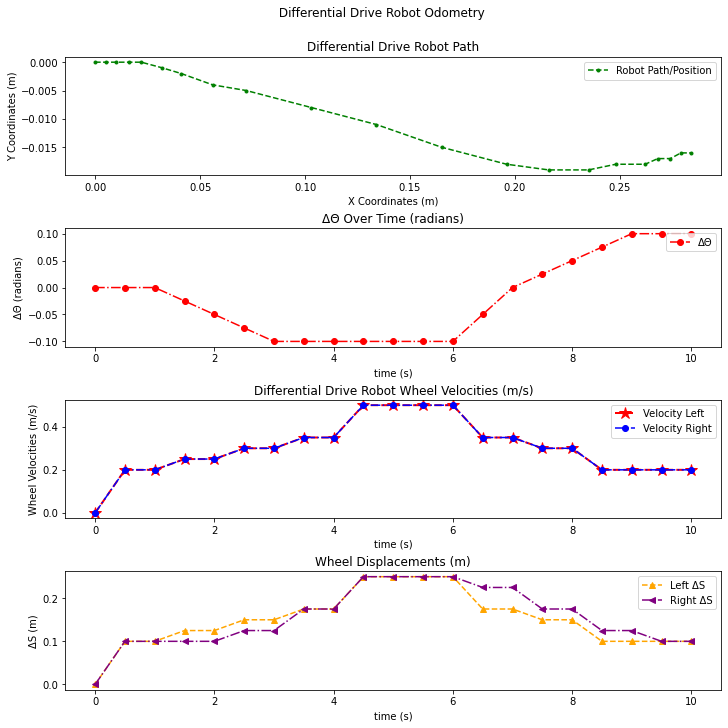

In [115]:
mobile_robot.robot_plots()

TypeError: type list doesn't define __round__ method